# Workshop name

**Author:** Martin Beneš, Verena Lachner

<div style="text-align: center">
<img src="https://www.uibk.ac.at/media/filer_public/00/c3/00c369ba-9e7a-42a4-9f73-466c81dc951a/universitaet-innsbruck-logo-cmyk-farbe.jpg" style="height: 5em; display: inline; padding-right: 2em" />
<img src="https://www.uncoverproject.eu/wp-content/uploads/2021/05/UNCOVER-Logog-440x92.5-final-1.0.png" style="height: 4em; display: inline; padding-left: 2em" />
</div>

<div style="text-align: center">
<a href="https://www.github.com/uibk-uncover/mip-stego-demo">
github.com/uibk-uncover/mip-stego-demo
</a>
</div>

## Notebook setup

For this notebook, we will use a sample image `00001.tif` from ALASKA database. Run following code chunk to download it.

In [137]:
# download 00001.tif from ALASKA website
import requests
res = requests.get('http://alaska.utt.fr/DATASETS/ALASKA_v2_TIFF_512_COLOR/00001.tif', verify=False)
with open('00001.tif', 'wb') as f:
    f.write(res.content)
assert res.status_code == 200, res.text

/opt/miniconda3/envs/dev/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'alaska.utt.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [208]:
import matplotlib as mpl
import numpy as np
np.set_printoptions(threshold=100)
mpl.rcParams['figure.figsize'] = (10, 3)
from PIL import Image
im = Image.open('00001.tif')  # load image
im = Image.open('/Users/martin/Datasets/girls.jpeg')  # load image
x = np.array(im.convert('L'))  # PIL to numpy
x.shape

(3024, 4032)

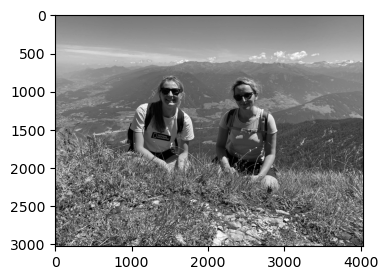

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.imshow(x,cmap = "gray");

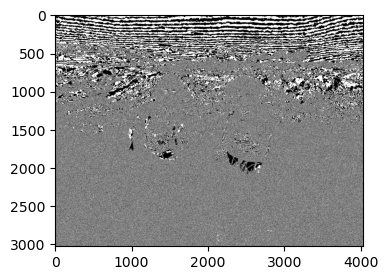

In [210]:
plt.imshow(x & 2,cmap = "gray");

In [211]:
def lsbr_sequential(x, alpha=1., seed=12345):
    # probability
    payload = int(np.ceil(alpha * x.size))
    probability = np.reshape([1/2.]*payload + [0]*(x.size - payload), x.shape)
    # simulate
    rng = np.random.default_rng(seed)
    to_be_changed = rng.random(x.shape) < probability
    # modify
    y = np.copy(x)
    y[to_be_changed & (x % 2 == 0)] += 1
    y[to_be_changed & (x % 2 != 0)] -= 1
    return y

def lsbr_permuted(x, alpha=1., seed=12345):
    # probability
    probability = np.ones(x.shape, dtype='float64') * alpha / e
    # simulate
    rng = np.random.default_rng(12345)
    to_be_changed = rng.random(x.shape) < probability
    # modify
    y = x.copy()
    y[to_be_changed & (x % 2 == 0)] += 1
    y[to_be_changed & (x % 2 != 0)] -= 1
    return y

## Histogram

1000 people tosses 100 times a fair coin, and count heads.

In [229]:
np.random.seed(12345)  # for reproducibility
tosses = np.random.randint(2, size=[1000, 100])  # toss
toss_sums = np.sum(tosses, axis=1)  # count heads
toss_sums  # print result

array([56, 50, 46, ..., 51, 44, 51])

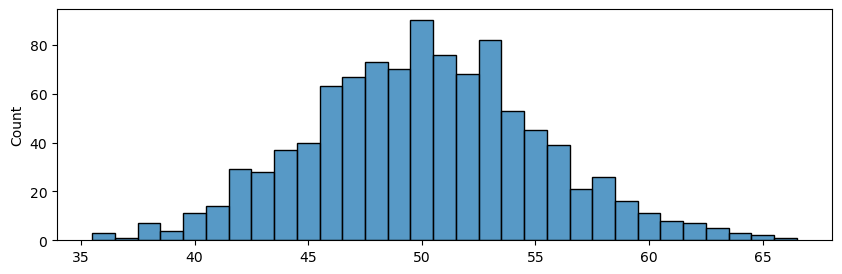

In [231]:
sns.histplot(toss_sums, discrete=True);  # plot result as histogram

## Image histogram

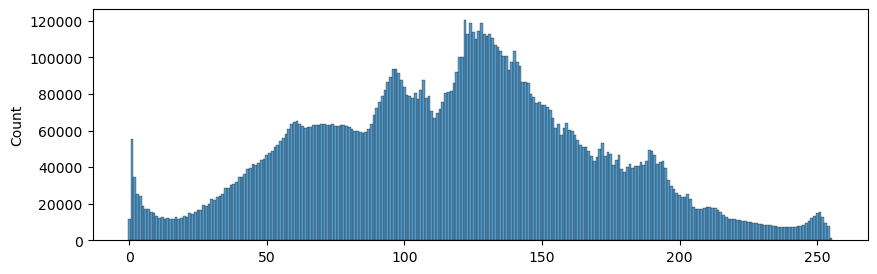

In [215]:
sns.histplot(x.flatten(), discrete=True);

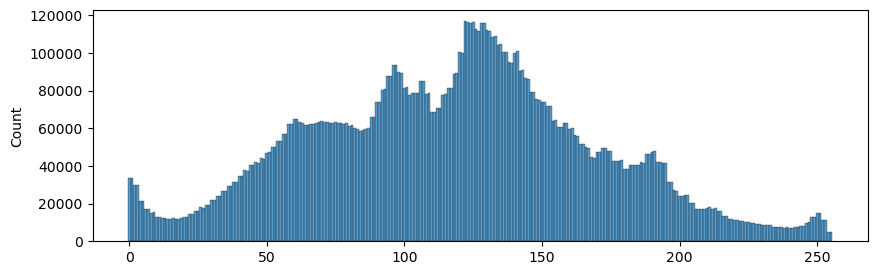

In [216]:
sns.histplot(lsbr_permuted(x, 1.).flatten(), discrete=True);

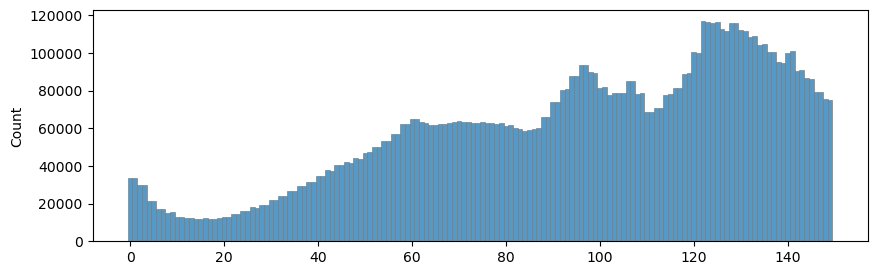

In [250]:
sns.histplot(lsbr_permuted(x, 1.).flatten(), binrange=(0-.5, 150-.5), binwidth=1.);

LSBr averages two neighbors (even and odd), s.t.,

$$\bar{h}_i=\frac{h_{i}+h_{i+1}}{2}$$

We can use Pearson's $\chi^2$ test to compare the bins to their average.

$$S=\frac{(h_0-\bar{h}_0)^2}{\bar{h}_0}+\dots+\frac{(h_{254}-\bar{h}_{254})^2}{\bar{h}_{254}}=\sum_{i=0}^{254}\frac{(h_i-\bar{h}_i)^2}{\bar{h}_i}$$

In [273]:
from scipy.stats import chi2
def attack(x):
    # Calculate the histogram
    h = np.histogram(x.flatten(), bins=255, range=(0,255))[0]

    # Construct even-odd histogram bin pairs
    hbar = (h[:-1] + h[1:]) / 2

    # Chi2 test
    S = np.sum((h[:-1:2] - hbar[::2])**2 / (hbar[::2] + 1e-18))
    pval = chi2.cdf(S, h.size-1)
    return 1 - pval

In [189]:
attack(x)

0.0

In [190]:
import stegolab2 as sl2
y = x + sl2.lsb.simulate(x, .5, seed=12345)
attack(y)

0.8352630752181873

## LSBr leaves traces

LSBr leaves traces.

In [13]:
#
alpha = 1.
e = 2  # efficiency; because every other pixel is changed

In [14]:
#
payload = int(np.ceil(alpha * x.size))
probability = np.reshape([1/e]*payload + [0]*(x.size - payload), x.shape)
rng = np.random.default_rng(12345)
to_be_changed = rng.random(x.shape) < probability
print('Relative payload:', alpha)
print('Change rate:', np.mean(to_be_changed))

# modify
y = x.copy()
y[to_be_changed & (x % 2 == 0)] += 1
y[to_be_changed & (x % 2 != 0)] -= 1

Relative payload: 1.0
Change rate: 0.4995994567871094


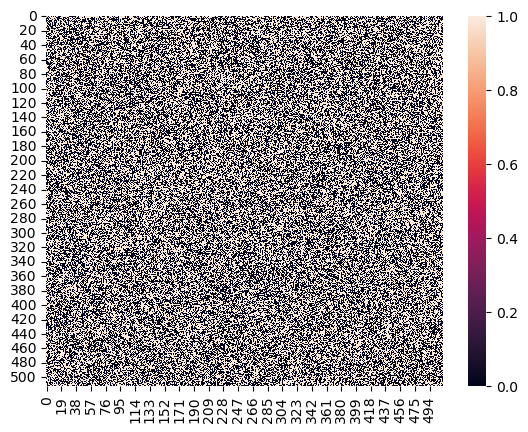

In [15]:
sns.heatmap(np.abs(y.astype('int') - x));

In [16]:
#
probability = np.ones(x.shape, dtype='float64') * alpha / e
rng = np.random.default_rng(12345)
to_be_changed = rng.random(x.shape) < probability
print('Relative payload:', alpha)
print('Change rate:', np.mean(to_be_changed))

# modify
y = x.copy()
y[to_be_changed & (x % 2 == 0)] += 1
y[to_be_changed & (x % 2 != 0)] -= 1

Relative payload: 1.0
Change rate: 0.4995994567871094


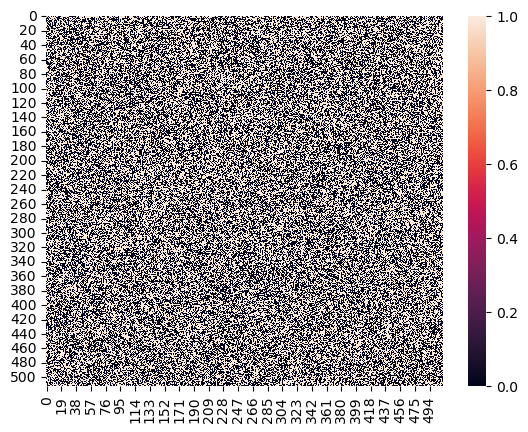

In [17]:
sns.heatmap(np.abs(y.astype('int') - x));

## We compare the histograms

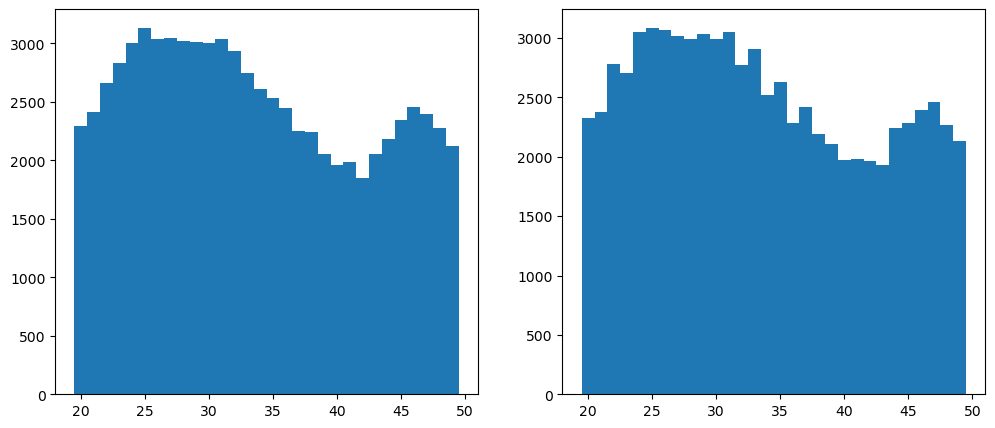

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (12,5))
start, end = 20, 50
ax[0].hist(x.flatten(), bins=end-start, range=(start-.5, end-.5));
ax[1].hist(y.flatten(), bins=end-start, range=(start-.5, end-.5));